In [1]:
import os, sys
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

from indicators import *


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [2]:
top100tech = ['AAPL', 'MSFT', 'TSM', 'NVDA', 'INTC', 'ASML', 'ADBE', 'CRM', 'AVGO', 'ORCL', 'CSCO', 'ACN', 'TXN', 'SHOP', 'QCOM', 'SAP', 'SNE', 'AMAT', 'INTU', 'NOW', 'SQ', 'IBM', 'MU', 'AMD',
'UBER', 'FIS', 'LRCX', 'FISV', 'SNOW', 'INFY', 'TEAM', 'ADSK', 'DELL', 'WDAY', 'VMW', 'ADI', 'NXPI', 'KLAC',
'CRWD', 'PLTR', 'DOCU', 'TEL', 'ERIC', 'MCHP', 'CDNS', 'CTSH',
'APH', 'SNPS', 'HPQ',
'PANW', 'OKTA','RNG','STM','MRVL','XLNX','WIT','MSI','SWKS','GLW','DDOG','ANSS','U','ZS','FTNT','STNE','ZBRA','KEYS','FTV','MXIM','COUP','GRMN','SPLK','HUBS','WORK','NET','FLT','CDW','CAJ','AFRM','PAYC','TER',
'VRSN','WDC', 'ZI',
'UMC','ANET','EPAM',
'UI','XM',
'GIB','TRMB',
'TYL','WIX','HPE','LYFT',
'LOGI',
'MPWR']

In [3]:
top10tech = top100tech[:10]

In [4]:
def process_stock_data_from_yf(data):
    
    df = pd.melt(data, ignore_index=False)
    df.columns = ['Variable', 'Ticker', 'Value']
    # this is a nicely formed dataframe of historical data
    nice_df = df.reset_index().pivot(index=['Ticker', 'Date'], columns=['Variable'], values=['Value'])
    nice_df.columns = nice_df.columns.droplevel()
    df = nice_df.reset_index()
    df.columns.name=None
    return df
    
    

In [5]:
data = yf.download(tickers = ' '.join(top10tech),
                   auto_adjust=True,
                  period='4y')

[*********************100%***********************]  10 of 10 completed


In [18]:
df = process_stock_data_from_yf(data)
df.head()

,Ticker,Date,Close,High,Low,Open,Volume
0,AAPL,2017-03-13,33.052044,33.106655,32.961818,32.968941,69686800.0
1,AAPL,2017-03-14,33.002182,33.158892,32.966563,33.075789,61236400.0
2,AAPL,2017-03-15,33.351227,33.420084,33.011682,33.101911,102767200.0
3,AAPL,2017-03-16,33.405842,33.484198,33.303739,33.412965,76928000.0
4,AAPL,2017-03-17,33.239635,33.479452,33.215890,33.479452,175540000.0


In [16]:
# compute all our technical markers for each of the stocks. 
dataset = df.groupby('Ticker').apply(lambda x: add_technical_markers(x, 14))

In [20]:
dataset

,Ticker,Date,Close,High,Low,Open,Volume,HH,LL,AV,SMA,SD,WILLR,ATR,DMH,DML,EMA,WMA,BBHIGH,BBLOW,PERBHIGH,PERBLOW,TRIMA,RSI,DX,PDI,NDI,ADX,ROC,MACD,CCI
0,AAPL,2017-03-13,33.052044,33.106655,32.961818,32.968941,69686800.0,33.106655,32.961818,6.968680e+07,33.052044,NaN,-37.705123,0.144837,0.000000,0.000000,33.052044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN
1,AAPL,2017-03-14,33.002182,33.158892,32.966563,33.075789,61236400.0,33.158892,32.961818,6.546160e+07,33.027113,0.035258,-81.480295,0.168582,0.052237,0.004745,33.025332,NaN,33.097628,32.956598,938.734934,934.734934,NaN,NaN,83.344552,30.985901,2.814832,83.344552,-0.150859,-0.000890,44.894230
2,AAPL,2017-03-15,33.351227,33.420084,33.011682,33.101911,102767200.0,33.420084,32.961818,7.789680e+07,33.135151,0.188781,-16.860063,0.251689,0.261192,0.045118,33.149825,NaN,33.512712,32.757590,177.521933,173.521933,NaN,NaN,70.540847,103.775817,17.926191,76.942699,0.905187,0.007441,19.006587
3,AAPL,2017-03-16,33.405842,33.484198,33.303739,33.412965,76928000.0,33.484198,32.961818,7.765460e+07,33.202824,0.205127,-43.420736,0.233881,0.064115,0.292058,33.228148,NaN,33.613078,32.792569,163.864577,159.864577,NaN,NaN,63.997924,27.413378,124.874384,72.627774,1.070427,0.012680,41.415027
4,AAPL,2017-03-17,33.239635,33.479452,33.215890,33.479452,175540000.0,33.484198,32.961818,9.723168e+07,33.210186,0.178407,-90.990446,0.239817,-0.004747,-0.087850,33.231145,NaN,33.566999,32.853373,188.148935,184.148935,NaN,NaN,89.747132,-1.979384,-36.631938,76.907614,0.567564,0.010130,34.250020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,TSM,2021-03-08,113.930000,121.000000,113.699997,120.540001,17199900.0,139.639999,113.489998,1.390645e+07,127.343574,7.208348,-96.849270,5.219289,-0.300003,-1.680000,124.847369,130.829337,141.760271,112.926877,19.666124,15.666124,132.143369,36.916915,69.696713,-5.747968,-32.188298,695.935844,-18.650484,-1.113128,-61.617292
10076,TSM,2021-03-09,116.379997,118.400002,115.330002,117.070000,17640800.0,137.949997,113.489998,1.428714e+07,125.922859,7.273474,-65.798191,5.256432,-2.599998,1.630005,123.718386,129.449718,140.469808,111.375911,19.312615,15.312615,131.758573,40.091277,436.085701,-49.463180,31.009720,726.161601,-14.596027,-1.581387,-55.347889
10077,TSM,2021-03-10,113.830002,118.029999,113.410004,117.800003,15185300.0,137.949997,113.410004,1.454219e+07,124.437145,7.479534,-90.909121,5.381431,-0.370003,-1.919998,122.399935,128.090670,139.396212,109.478077,18.637019,14.637019,131.222757,37.950742,67.685363,-6.875546,-35.678208,729.824243,-15.449753,-2.108820,-51.798497
10078,TSM,2021-03-11,120.580002,120.800003,117.070000,118.239998,15044000.0,135.279999,113.410004,1.484734e+07,123.288573,6.646426,-5.898151,5.642146,2.770004,3.659996,122.157277,126.307812,136.581425,109.995721,20.549604,16.549604,130.527655,46.147260,13.841240,49.094871,64.868865,730.406110,-11.766429,-2.080529,-29.112199


<AxesSubplot:xlabel='Date'>

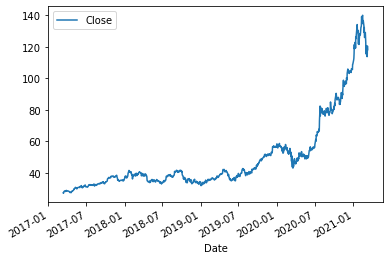

In [32]:
dataset.loc[dataset['Ticker']=='TSM', ['Date', 'Close']].set_index('Date').plot()

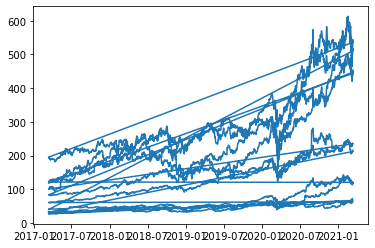

In [40]:
plt.plot('Date', 'Close', data=dataset)

In [44]:
dataset.shape

(10080, 31)

In [16]:
dataset.head(16)

,Ticker,Date,Close,High,Low,Open,Volume,HH,LL,AV,SMA,SD,WILLR,ATR,DMH,DML,EMA,WMA,BBHIGH,BBLOW,PERBHIGH,PERBLOW,TRIMA,RSI,DX,PDI,NDI,ADX,ROC,MACD,CCI
0,AAPL,2017-03-13,33.052044,33.106655,32.961818,32.968941,69686800.0,33.106655,32.961818,6.968680e+07,33.052044,NaN,-37.705123,0.144837,0.000000,0.000000,33.052044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN
1,AAPL,2017-03-14,33.002182,33.158892,32.966563,33.075789,61236400.0,33.158892,32.961818,6.546160e+07,33.027113,0.035258,-81.480295,0.168582,0.052237,0.004745,33.025332,NaN,33.097628,32.956598,938.734934,934.734934,NaN,NaN,83.344552,30.985901,2.814832,83.344552,-0.150859,-0.000890,44.894230
2,AAPL,2017-03-15,33.351227,33.420084,33.011682,33.101911,102767200.0,33.420084,32.961818,7.789680e+07,33.135151,0.188781,-16.860063,0.251689,0.261192,0.045118,33.149825,NaN,33.512712,32.757590,177.521933,173.521933,NaN,NaN,70.540847,103.775817,17.926191,76.942699,0.905187,0.007441,19.006587
3,AAPL,2017-03-16,33.405842,33.484198,33.303739,33.412965,76928000.0,33.484198,32.961818,7.765460e+07,33.202824,0.205127,-43.420736,0.233881,0.064115,0.292058,33.228148,NaN,33.613078,32.792569,163.864577,159.864577,NaN,NaN,63.997924,27.413378,124.874384,72.627774,1.070427,0.012680,41.415027
4,AAPL,2017-03-17,33.239635,33.479452,33.215890,33.479452,175540000.0,33.484198,32.961818,9.723168e+07,33.210186,0.178407,-90.990446,0.239817,-0.004747,-0.087850,33.231145,NaN,33.566999,32.853373,188.148935,184.148935,NaN,NaN,89.747132,-1.979384,-36.631938,76.907614,0.567564,0.010130,34.250020
5,AAPL,2017-03-20,33.588676,33.598173,33.296619,33.336984,86168000.0,33.598173,32.961818,9.538773e+07,33.273268,0.222124,-3.149067,0.259604,0.118721,0.080729,33.313871,NaN,33.717515,32.829020,151.796100,147.796100,NaN,NaN,19.048211,45.731594,31.097101,65.335733,1.623599,0.020136,34.841057
6,AAPL,2017-03-21,33.204002,33.906835,33.177884,33.742999,158119600.0,33.906835,32.961818,1.043494e+08,33.263373,0.204453,-96.416927,0.326654,0.308662,-0.118736,33.290720,NaN,33.672279,32.854466,164.694187,160.694187,NaN,NaN,225.033073,94.492179,-36.349062,91.951956,0.459755,0.012707,60.646578
7,AAPL,2017-03-22,33.579170,33.621912,33.185014,33.206387,103440800.0,33.906835,32.961818,1.042358e+08,33.302847,0.219763,-9.782978,0.340434,-0.284923,0.007131,33.347136,NaN,33.742373,32.863322,153.540122,149.540122,NaN,NaN,105.133814,-83.693982,2.094581,93.835079,1.594837,0.021424,20.348349
8,AAPL,2017-03-23,33.460449,33.617162,33.386843,33.541179,81385200.0,33.906835,32.961818,1.016969e+08,33.320359,0.212176,-68.041529,0.328199,-0.004749,0.201828,33.368000,NaN,33.744710,32.896008,159.041477,155.041477,NaN,NaN,104.819840,-1.447122,61.495673,95.208174,1.235643,0.022698,38.048946
9,AAPL,2017-03-24,33.393963,33.655151,33.325106,33.598164,89582400.0,33.906835,32.961818,1.004854e+08,33.327719,0.201391,-79.137164,0.328384,0.037989,-0.061736,33.372549,NaN,33.730500,32.924938,167.487981,163.487981,NaN,NaN,419.942710,11.568494,-18.800098,131.289789,1.034487,0.020675,35.841824


In [45]:
dataset.describe()

,Close,High,Low,Open,Volume,HH,LL,AV,SMA,SD,WILLR,ATR,DMH,DML,EMA,WMA,BBHIGH,BBLOW,PERBHIGH,PERBLOW,TRIMA,RSI,DX,PDI,NDI,ADX,ROC,MACD,CCI
count,10080.000000,10080.000000,10080.000000,10080.000000,1.008000e+04,10080.000000,10080.000000,1.008000e+04,10080.000000,10070.000000,1.008000e+04,10080.000000,10080.000000,10080.000000,10080.000000,9950.000000,10070.000000,10070.000000,10070.000000,10070.000000,9950.000000,9940.000000,1.006900e+04,10080.000000,10080.000000,1.007000e+04,10080.000000,10080.000000,10070.000000
mean,154.202366,156.045456,152.215354,154.215577,2.336512e+07,161.244068,143.855264,2.333457e+07,152.952624,4.328349,-4.694868e+01,4.269339,0.194032,0.190056,152.927848,153.456838,161.680438,144.367043,56.530020,52.530020,152.534551,55.630133,1.009388e+04,6.498406,5.826725,1.024062e+04,1.875434,1.416076,14.543137
std,118.948267,120.571310,117.199381,119.040334,4.129478e+07,124.961183,110.253650,3.865799e+07,117.702654,4.875266,3.072996e+01,4.491594,3.849526,4.075947,117.564471,117.691630,125.205445,110.605943,54.321299,54.321299,116.667619,11.576754,3.676641e+05,66.914053,70.029727,9.832360e+04,7.067888,4.054675,51.864796
min,27.122673,27.348623,27.113984,27.174815,1.913000e+05,27.435525,27.113984,4.171571e+05,27.248683,0.012787,-1.000000e+02,0.144837,-43.387152,-46.946157,27.239682,27.982607,27.605093,26.692518,8.037656,4.037656,27.866110,18.890778,0.000000e+00,-449.429295,-544.398188,7.499858e+00,-38.722400,-25.861245,-706.977168
25%,50.898900,51.430890,50.411542,50.943921,3.069425e+06,53.143552,48.151017,3.332027e+06,50.818133,1.084116,-7.407388e+01,1.069970,-0.681750,-0.665673,50.780876,50.867736,53.177214,48.294688,33.056192,29.056192,50.692201,47.880078,1.515169e+01,-30.871581,-31.390851,5.551843e+01,-1.743438,-0.090165,-25.634167
50%,130.839996,132.391796,129.291918,130.754008,8.780500e+06,136.837152,122.789850,9.234793e+06,130.099286,2.603648,-4.561428e+01,2.810094,0.094359,0.163408,129.729065,131.545811,136.593568,122.926639,47.440943,43.440943,130.843419,55.885168,3.603631e+01,5.799383,10.248977,8.286745e+01,2.149184,0.698670,24.781479
75%,218.727360,221.978799,215.715525,219.297737,2.190818e+07,230.300003,204.343185,2.307572e+07,218.142208,5.882042,-1.861874e+01,5.787840,1.046073,1.184186,217.984128,218.921067,231.439160,205.124891,69.169833,65.169833,218.053556,63.844376,8.069029e+01,42.669986,47.019745,1.433989e+02,5.842206,2.585995,55.428894
max,613.210022,614.900024,599.169983,606.840027,4.268848e+08,614.900024,559.659973,3.155055e+08,582.634290,41.908829,1.312337e-12,34.143489,59.619995,38.669998,579.551148,589.851623,635.333070,554.851308,2488.451536,2484.451536,574.697402,92.784135,2.327154e+07,607.968514,432.043602,1.662365e+06,53.437230,30.346531,162.709976


In [18]:
X = dataset['Close']

In [19]:
tickers = dataset['Ticker'].unique()

### Train test split

In [164]:
train = dataset.loc[dataset['Date'] < "2020-03-13"]
test = dataset.loc[dataset['Date'] > "2020-03-13"]

In [178]:
train.head()

,Ticker,Date,Close,High,Low,Open,Volume,HH,LL,AV,SMA,SD,WILLR,ATR,DMH,DML,EMA,WMA,BBHIGH,BBLOW,PERBHIGH,PERBLOW,TRIMA,RSI,DX,PDI,NDI,ADX,ROC,MACD,CCI
0,AAPL,2017-03-13,33.052044,33.106655,32.961818,32.968941,69686800.0,33.106655,32.961818,69686800.0,33.052044,NaN,-37.705123,0.144837,0.000000,0.000000,33.052044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN
1,AAPL,2017-03-14,33.002182,33.158892,32.966563,33.075789,61236400.0,33.158892,32.961818,65461600.0,33.027113,0.035258,-81.480295,0.168582,0.052237,0.004745,33.025332,NaN,33.097628,32.956598,938.734934,934.734934,NaN,NaN,83.344552,30.985901,2.814832,83.344552,-0.150859,-0.000890,44.894230
2,AAPL,2017-03-15,33.351227,33.420084,33.011682,33.101911,102767200.0,33.420084,32.961818,77896800.0,33.135151,0.188781,-16.860063,0.251689,0.261192,0.045118,33.149825,NaN,33.512712,32.757590,177.521933,173.521933,NaN,NaN,70.540847,103.775817,17.926191,76.942699,0.905187,0.007441,19.006587
3,AAPL,2017-03-16,33.405842,33.484198,33.303739,33.412965,76928000.0,33.484198,32.961818,77654600.0,33.202824,0.205127,-43.420736,0.233881,0.064115,0.292058,33.228148,NaN,33.613078,32.792569,163.864577,159.864577,NaN,NaN,63.997924,27.413378,124.874384,72.627774,1.070427,0.012680,41.415027
4,AAPL,2017-03-17,33.239635,33.479452,33.215890,33.479452,175540000.0,33.484198,32.961818,97231680.0,33.210186,0.178407,-90.990446,0.239817,-0.004747,-0.087850,33.231145,NaN,33.566999,32.853373,188.148935,184.148935,NaN,NaN,89.747132,-1.979384,-36.631938,76.907614,0.567564,0.010130,34.250020


In [179]:
test.head()

,Ticker,Date,Close,High,Low,Open,Volume,HH,LL,AV,SMA,SD,WILLR,ATR,DMH,DML,EMA,WMA,BBHIGH,BBLOW,PERBHIGH,PERBLOW,TRIMA,RSI,DX,PDI,NDI,ADX,ROC,MACD,CCI
757,AAPL,2020-03-16,60.086731,64.271785,59.538479,60.022229,322423600.0,75.415404,59.538479,2.984721e+08,69.243611,4.418363,-88.417147,5.198280,-5.169938,-3.212602,68.978645,70.578619,78.080337,60.406884,17.671779,13.671779,73.884662,37.062248,23.350148,-99.454789,-61.801263,56.206085,-15.922655,-2.762315,-73.817971
758,AAPL,2020-03-17,62.728752,63.907114,59.141557,61.401539,324056000.0,75.415404,59.141557,3.074722e+08,68.538540,4.624393,-24.726636,5.337025,-0.364671,-0.396922,68.145326,70.037125,77.787327,59.289754,16.821088,12.821088,73.189008,40.582316,4.234733,-6.832847,-7.437143,48.130641,-13.596450,-2.974102,-67.412611
759,AAPL,2020-03-18,61.193157,62.019254,58.824021,59.481427,300233600.0,75.415404,58.824021,3.060170e+08,68.062764,5.025490,-25.854042,5.267032,-1.887860,-0.317536,67.218370,70.064958,78.113745,58.011784,15.543507,11.543507,72.523820,39.209672,71.203719,-35.842960,-6.028747,52.750172,-9.816459,-3.216488,-67.576618
760,AAPL,2020-03-19,60.724293,62.723793,60.185966,61.371774,271857200.0,75.415404,58.824021,2.949436e+08,67.556333,5.396031,-78.787888,5.057761,0.704539,1.361945,66.352493,70.030558,78.348396,56.764270,14.519633,10.519633,71.881529,38.778385,31.812796,13.929857,26.927829,52.363877,-10.455074,-3.412670,-50.254658
761,AAPL,2020-03-20,56.869179,62.473238,56.561562,61.319677,401693200.0,75.415404,56.561562,2.992505e+08,66.323568,5.739720,-94.796452,4.982452,-0.250555,-3.624404,65.088051,68.989982,77.803007,54.844129,13.555193,9.555193,71.179965,35.336681,87.067990,-5.028750,-72.743391,58.312629,-23.282347,-3.787734,-52.702287


### Convert one stock into x and y format for input to model

In [138]:
def apply_rolling(stock, trail_size):
    x = []
    y = []
    for i in range(trail_size, len(stock)):
        x.append(stock.drop(columns=['Date', 'Ticker']).iloc[i-trail_size : i].values)
        y.append(stock['Close'].iloc[i])
        
    return np.array(x), np.array(y)

In [139]:
x, y = apply_rolling(dataset.loc[dataset['Ticker']=='AAPL'], trail_size=3)

In [130]:
x.shape

(1005, 3, 29)

In [131]:
y.shape

(1005,)

### Parameters

In [167]:
trail_size=14

### Convert all stocks into x and y for model input

In [153]:
def roll_all_stocks(dataset, trail_size):
    res = dataset.groupby('Ticker').apply(lambda x: apply_rolling(x, trail_size=trail_size))
    x = [x[0] for x in res.values]
    y = [x[1] for x in res.values]
    return np.concatenate(x), np.concatenate(y)

In [168]:
x_train, y_train = roll_all_stocks(train, trail_size)

In [169]:
x_train.shape

(7420, 14, 29)

In [170]:
y_train.shape

(7420,)

In [171]:
x_test, y_test = roll_all_stocks(test, trail_size)

In [172]:
x_test.shape

(2370, 14, 29)

In [173]:
y_test.shape

(2370,)

### Model Design

In [174]:
model = Sequential()
model.add(LSTM(units=500, input_shape=(trail_size, 29), return_sequences=True))
model.add(LSTM(units=250, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='linear'))

In [175]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 14, 500)           1060000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 14, 250)           751000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                60200     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 26        
Total params: 1,875,051
Trainable params: 1,875,051
Non-trainable params: 0
____________________________________________

In [176]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [177]:
model.fit(x_train, y_train, epochs=40, validation_data=(x_test, y_test))

Epoch 1/40
232/232 [==============================] - 6s 14ms/step - loss: 23608.2930 - val_loss: 84018.2578
Epoch 2/40
232/232 [==============================] - 3s 11ms/step - loss: 23248.7261 - val_loss: 81784.3203
Epoch 3/40
232/232 [==============================] - 3s 11ms/step - loss: 21239.9225 - val_loss: 78377.5625
Epoch 4/40
232/232 [==============================] - 3s 11ms/step - loss: 20025.4657 - val_loss: 74135.5781
Epoch 5/40
232/232 [==============================] - 3s 11ms/step - loss: 17878.9379 - val_loss: 69433.1094
Epoch 6/40
232/232 [==============================] - 3s 11ms/step - loss: 15278.9945 - val_loss: 64527.2305
Epoch 7/40
232/232 [==============================] - 3s 11ms/step - loss: 13860.7491 - val_loss: 59727.7500
Epoch 8/40
232/232 [==============================] - 3s 11ms/step - loss: 11678.9017 - val_loss: 55281.0547
Epoch 9/40
232/232 [==============================] - 2s 11ms/step - loss: 10176.5341 - val_loss: 51354.7812
Epoch 10/40
232/232